## Generate a timeseries from the data

First, crawl the instrument for all of the data for the past 30 days.


In [1]:
import requests, json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import glob
import datetime as dt
import requests
from tqdm import tqdm
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-64gxim6l because the default path (/u/pdaniel/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


__Load data that from classifier__

In [2]:
last_file = sorted(glob.glob("../data/classified-csv/classified_*.csv"))[-1]
df = pd.read_csv(last_file)
df.index = pd.to_datetime(df['dateTime'])

critter_cols = [col for col in df.columns if col not in ['volume_analyzed','dateTime','nsample', 'inhibitTime', 'runTime', 'syringeSize','fileName','volume_analyzed','nsamples']]
not_species = ['dateTime',"inhibitTime","runTime","nsample","volume_analyzed","syringeSize",'fileName','nsamples','nsample','ntotals','volume_analyzed','hab','date']
habs = ["Pseudo-nitzschia","Alexandrium_singlet","Dinophysis","Lingulodinium","Cochlodinium","Prorocentrum","Gymnodinium","Karenia","Protoperidinium"]
species = [cols for cols in df.columns if cols not in not_species]
not_habs = [cols for cols in df.columns if (cols not in not_species) & (cols not in habs)]

# df['hab'] = df['variable'].isin(habs)

def this_week(ax, n_days=10):
    """set x-lim of an axes to the past week"""
    now = dt.datetime.now()
    week_ago = now - dt.timedelta(days=n_days)
    ax.set_xlim(week_ago, now)
    
flowrate = 0.25; # .25 mls per minute
df['volume_analyzed'] = ((df['runTime'] - df['inhibitTime']) * flowrate)/60
df['nsamples'] = df[critter_cols].sum(axis=1)
df[critter_cols] = df[critter_cols].divide(df['volume_analyzed'],axis=0)

__Create list of columns of just the model classes (no metadata) for plotting__

In [6]:
now = dt.datetime.now()
week_ago = now - dt.timedelta(days=60)

top_cols = df.query("index > @week_ago").iloc[-1][critter_cols].sort_values(ascending=False)[:15]
top_cols = list(top_cols.index)
top_cols

['Centric',
 'NanoP_less10',
 'Chaetoceros',
 'Ciliates',
 'Prorocentrum',
 'Ceratium',
 'Entomoneis',
 'Dictyocha',
 'Pennate',
 'Scrip_Het',
 'Phaeocystis',
 'Gymnodinium',
 'Dinophysis',
 'Gyrodinium',
 'Det_Cer_Lau']

__Reindex the data to add NANs were the data is missing__


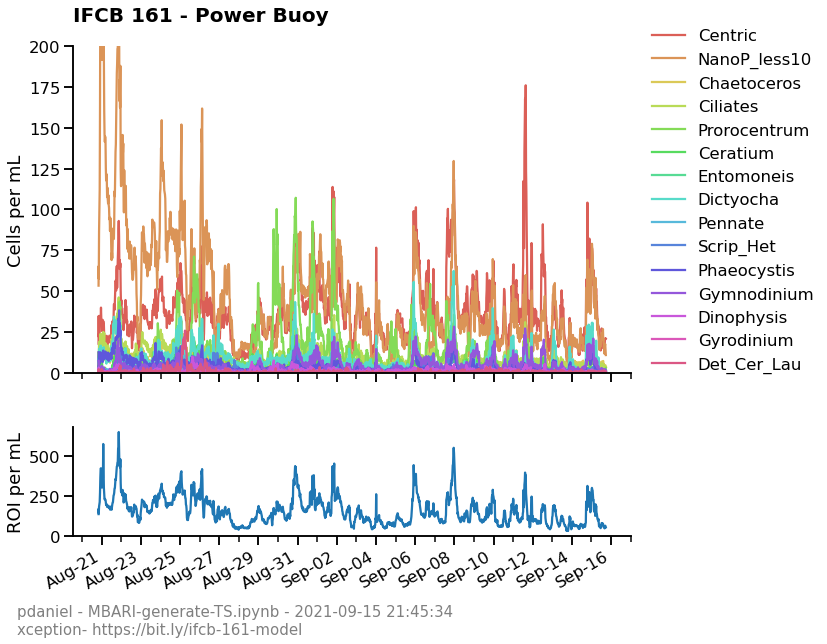

In [37]:
sns.set_context('talk')
fig, (ax,ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=.25)

fig.set_size_inches(10,10)

colors = sns.color_palette("hls", len(top_cols))
ax.set_prop_cycle('color', colors)

ax.set_title("IFCB 161 - Power Buoy", loc="left",pad=25,fontsize=20,fontweight='bold')


p1 = df[top_cols].plot(ax=ax,)
ax.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left',frameon=False)
ax.set_ylabel("Cells per mL")

# fig.autofmt_xdate()
# Major ticks every 6 months.
major_ticks = mdates.DayLocator(interval=2)
# ax.xaxis.set_major_locator(major_ticks)

# Minor ticks every month.
# minor_ticks = mdates.HourLocator(byhour=range(2,24,2))
minor_ticks = mdates.DayLocator(interval=1)
# ax.xaxis.set_minor_locator(minor_ticks)

# Text in the x axis will be displayed in 'YYYY-mm' format.
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax.set_xlabel("")
# this_week(ax, n_days=3)
# ax.set_ylim(0, 130)
df['nsamples'].plot(ax=ax2)

ax2.xaxis.set_major_locator(major_ticks)
ax2.xaxis.set_minor_locator(minor_ticks)
# ax.xaxis.set_minor_locator(minor_ticks)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax.set_xlabel("")
ax.set_ylim(0, 200)
# ax2.set_ylim(0, 2500)

ax2.set_ylabel('ROI per mL')

ax2.text(-.1,
         -.8,
         'pdaniel - MBARI-generate-TS.ipynb - {}\nxception- https://bit.ly/ifcb-161-model'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

# this_week(ax2, n_days=60)
ax2.set_xlabel("")



sns.despine(ax=ax2)
sns.despine(ax=ax)

fig.autofmt_xdate()

plt.savefig('../figures/161-classified-all-scaled.png',dpi=300,bbox_inches='tight',transparent=False)




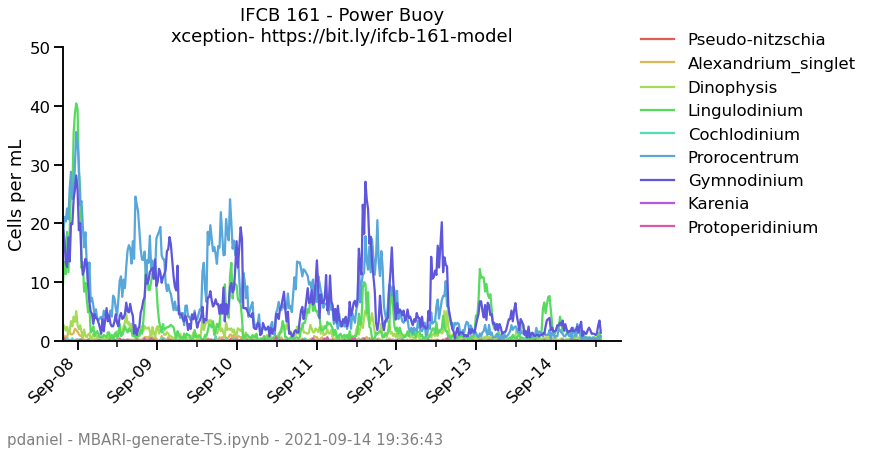

In [6]:
sns.set_context('talk')
fig, ax = plt.subplots(constrained_layout=False)
plt.subplots_adjust(hspace=.1)
fig.set_size_inches(10,6)

colors = sns.color_palette("hls", len(habs))
ax.set_prop_cycle('color', colors)


p1 = df[habs].plot(ax=ax,)
ax.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left',frameon=False)
ax.set_ylabel("Cells per mL")

# fig.autofmt_xdate()
# Major ticks every 6 months.
major_ticks = mdates.DayLocator(interval=1)
ax.xaxis.set_major_locator(major_ticks)

# Minor ticks every month.
minor_ticks = mdates.HourLocator(12)
ax.xaxis.set_minor_locator(minor_ticks)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax.set_xlabel("")
this_week(ax, n_days=7)
ax.set_ylim(0, 50)

ax.text(-.1,
         -.35,
         'pdaniel - MBARI-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

plt.title("IFCB 161 - Power Buoy\nxception- https://bit.ly/ifcb-161-model")

sns.despine()
# plt.savefig('../figures/161-classified-top-habs-7day.png',dpi=300,bbox_inches='tight',transparent=False)

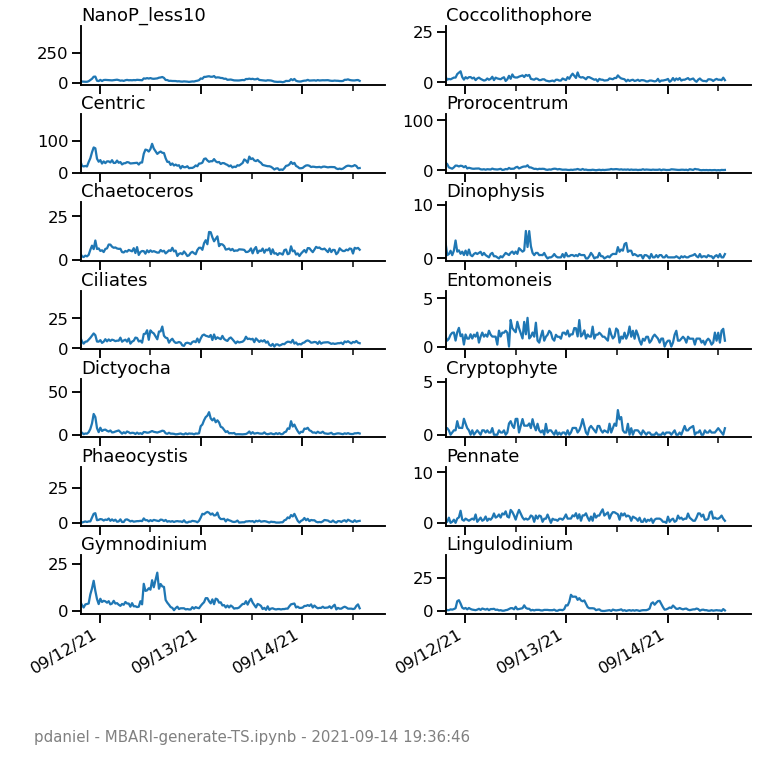

In [7]:
sns.set_context('talk')
fig, axes = plt.subplots(nrows=7,ncols=2, constrained_layout=False)
plt.subplots_adjust(hspace=.5)
fig.set_size_inches(12,12)
# colors = sns.color_palette(palette="husl", n_colors=5)
# ax.set_prop_cycle('color', colors)
major_ticks = mdates.DayLocator(interval=1)
minor_ticks = mdates.HourLocator(12)


ix = 0
for i in range(2):
    for j in range(7):
        current_ax = axes[j,i]
        current_ax = df[top_cols[ix]].plot(ax=current_ax)
        current_ax.xaxis.set_major_locator(major_ticks)
        current_ax.xaxis.set_minor_locator(minor_ticks)
        current_ax.set_title(top_cols[ix], loc="left",y=.99)
        current_ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
        current_ax.set_xlabel("")
#         if ix == 0:
#             current_ax.set_ylim(0,2500)
#         elif ix < 7:
#             current_ax.set_ylim(0,500)
#         else:
#         current_ax.set_ylim(0,250)
        
        if j != 6:
            current_ax.set_xticklabels([])
        ix += 1
        this_week(current_ax,n_days=3)

current_ax.text(-.1,
         -.2,
         'pdaniel - MBARI-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')
sns.despine()
# plt.savefig('../figures/161-classified-each-top.png',dpi=300,bbox_inches='tight',transparent=False)



In [9]:
long = pd.melt(df[top_cols].reset_index(), id_vars='dateTime', value_vars=top_cols)
long.head()

,dateTime,variable,value
0,2021-08-20 20:02:27,NanoP_less10,53.331677
1,2021-08-20 20:09:49,NanoP_less10,65.268158
2,2021-08-20 20:17:12,NanoP_less10,57.542174
3,2021-08-20 20:38:27,NanoP_less10,86.194198
4,2021-08-20 21:25:51,NanoP_less10,112.146190


In [10]:
# alt.Chart(long).mark_line(point=True).encode(
#     x='dateTime:T',
#     y='value:Q',
#     color='variable:N'
# )

In [21]:
df_norm = df[critter_cols].divide(df['nsamples'],axis=0)


Only Plot the Top 10 for the enture month

In [22]:
df['nsamples'] = df[critter_cols].sum(axis=1)
df_norm = df[critter_cols].divide(df['nsamples'],axis=0)
top_cols = df.query("index > @week_ago").iloc[-1][critter_cols].sort_values(ascending=False)[:15]
top_cols = list(top_cols.index)
top_cols

['Centric',
 'NanoP_less10',
 'Chaetoceros',
 'Ciliates',
 'Prorocentrum',
 'Ceratium',
 'Entomoneis',
 'Dictyocha',
 'Pennate',
 'Scrip_Het',
 'Phaeocystis',
 'Gymnodinium',
 'Dinophysis',
 'Gyrodinium',
 'Det_Cer_Lau']

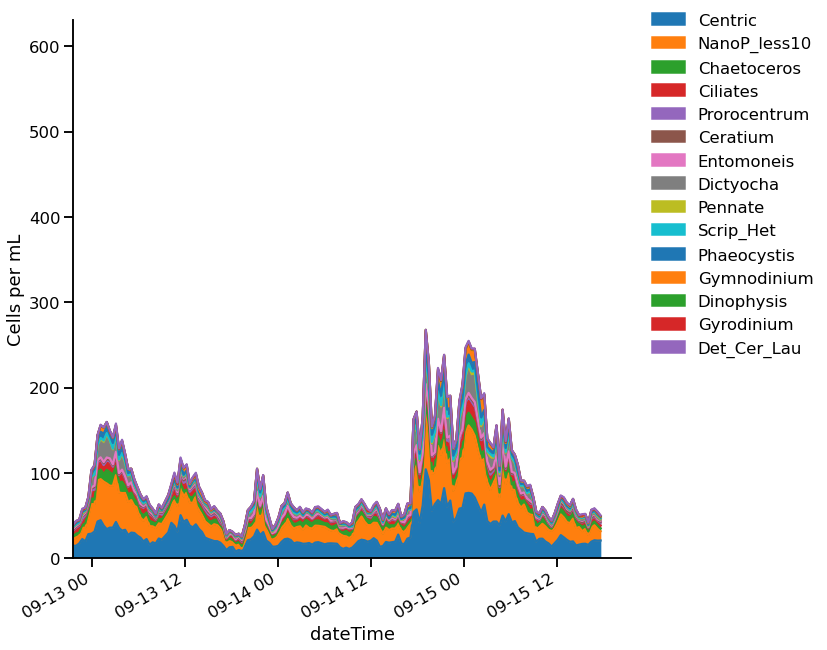

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(10,11)

# colors = sns.color_palette("hls", len(top_cols))
# ax.set_prop_cycle('color', colors)

colors = sns.color_palette(palette="tab10", n_colors=len(top_cols))
ax.set_prop_cycle('color', colors)
    
df[top_cols].plot.area(ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Cells per mL")

# this_week(ax,n_days=3)
# ax.set_xlim("2021-09-16")
sns.despine()
# plt.savefig('../figures/161-classified-stacked-top-3-day.png',dpi=300,bbox_inches='tight',transparent=False)

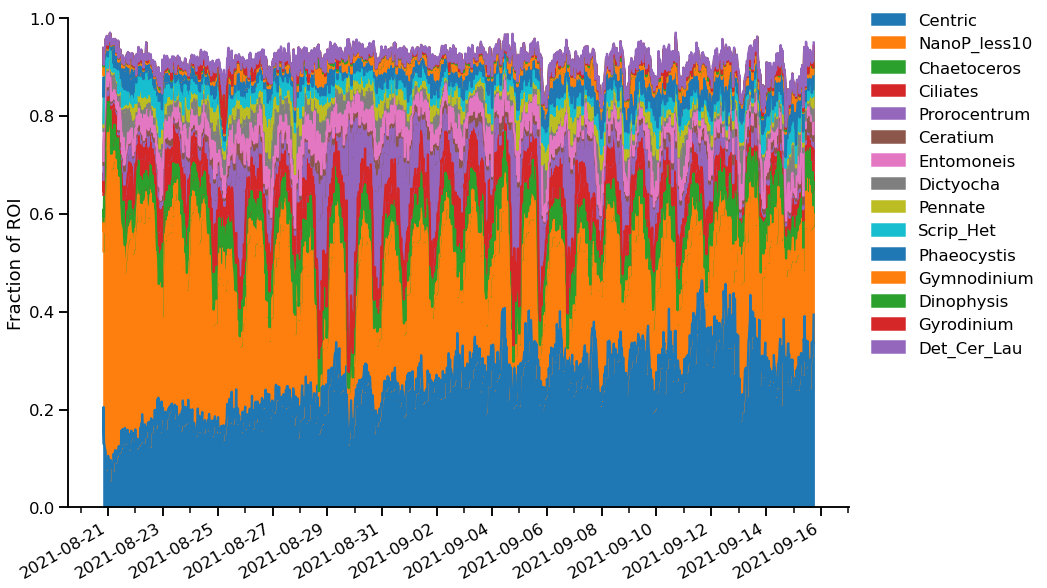

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(14,10)

colors = sns.color_palette(palette="tab10", n_colors=len(top_cols))
ax.set_prop_cycle('color', colors)

df_norm[top_cols].plot.area(ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Fraction of ROI")
ax.set_ylim(0,1)
# fig.autofmt_xdate()
# Major ticks every 6 months.
major_ticks = mdates.DayLocator(interval=2)
ax.xaxis.set_major_locator(major_ticks)

# Minor ticks every month.
# minor_ticks = mdates.HourLocator(byhour=range(2,24,2))
minor_ticks = mdates.DayLocator(interval=1)
ax.xaxis.set_minor_locator(minor_ticks)
# this_week(ax,n_days=3)
ax.set_xlabel("")
# ax.set_xlim("2021-09-16")
sns.despine()
plt.savefig('../figures/161-classified-relative-all.png',dpi=300,bbox_inches='tight',transparent=False)

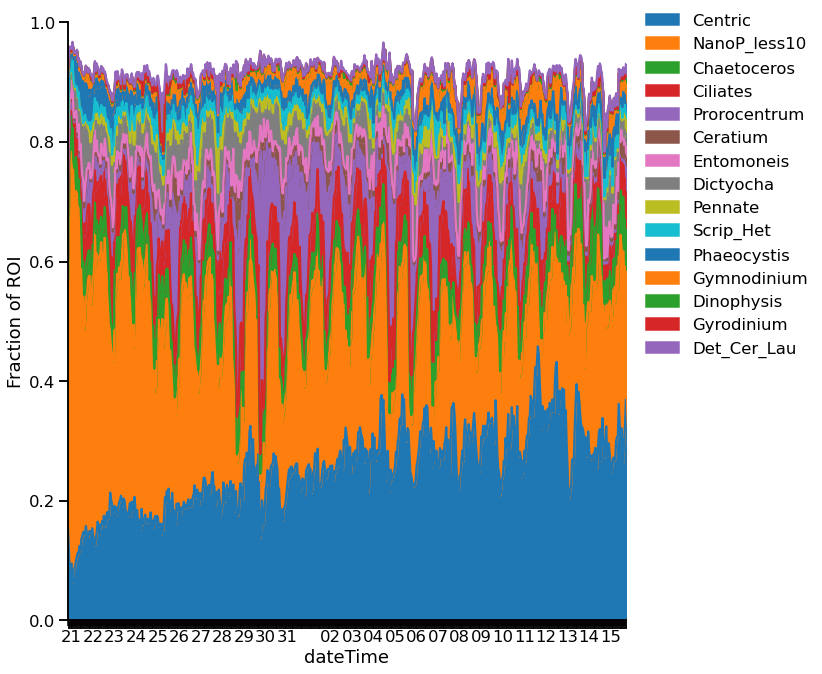

In [31]:


fig, ax = plt.subplots()
fig.set_size_inches(10,11)

colors = sns.color_palette(palette="tab10", n_colors=len(top_cols))
ax.set_prop_cycle('color', colors)

df_norm.resample("1H").mean()[top_cols].plot.area(ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Fraction of ROI")
ax.set_ylim(0,1)
# fig.autofmt_xdate()
# Major ticks every 6 months.
major_ticks = mdates.DayLocator(interval=2)
ax.xaxis.set_major_locator(major_ticks)

# Minor ticks every month.
# minor_ticks = mdates.HourLocator(byhour=range(2,24,2))
minor_ticks = mdates.DayLocator(interval=1)
ax.xaxis.set_minor_locator(minor_ticks)
# this_week(ax,n_days=3)

# ax.set_xlim("2021-09-16")
sns.despine()
# plt.savefig('../figures/161-classified-relative-top.png',dpi=300,bbox_inches='tight',transparent=False)

In [29]:
df_norm.resample("1H").mean()

,Akashiwo,Alexandrium_singlet,Amy_Gony_Protoc,Asterionellopsis,Bacteriastrum,Centric,Ceratium,Chaetoceros,Ciliates,Coccolithophore,...,Pyrocystis,Rhiz_Prob,Scrip_Het,Skeletonema,Steph_Melo,Thalassionema,Tropidoneis,Umbilicosphaera,cyst,zooplankton_misc
dateTime,,,,,,,,,,,,,,,,,,,,,
2021-08-20 20:00:00,0.000869,0.000000,0.001852,0.003395,0.000000,0.155558,0.022646,0.036431,0.070840,0.024038,...,0.0,0.002213,0.006786,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.007944
2021-08-20 21:00:00,0.002313,0.000000,0.001408,0.001306,0.000000,0.117500,0.017600,0.041519,0.074297,0.020606,...,0.0,0.000905,0.002415,0.000504,0.0,0.000504,0.000000,0.000504,0.0,0.006939
2021-08-20 22:00:00,0.002037,0.000577,0.001153,0.001498,0.000000,0.086435,0.008378,0.029246,0.058385,0.016180,...,0.0,0.000000,0.002613,0.000000,0.0,0.000539,0.000000,0.000307,0.0,0.006072
2021-08-20 23:00:00,0.002046,0.000000,0.001332,0.001639,0.000000,0.090166,0.010249,0.032415,0.047176,0.020441,...,0.0,0.002603,0.002589,0.000643,0.0,0.000000,0.000000,0.000230,0.0,0.003241
2021-08-21 00:00:00,0.002292,0.000224,0.002576,0.000449,0.000000,0.095079,0.012820,0.038133,0.059890,0.019162,...,0.0,0.001417,0.001886,0.000242,0.0,0.000449,0.000000,0.000000,0.0,0.002806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-15 13:00:00,0.011634,0.000000,0.001511,0.002931,0.000000,0.291142,0.005952,0.092463,0.064212,0.023448,...,0.0,0.002841,0.004442,0.000000,0.0,0.002841,0.000000,0.003021,0.0,0.005952
2021-09-15 14:00:00,0.006874,0.002042,0.002042,0.007579,0.000896,0.264729,0.017185,0.090636,0.063787,0.014952,...,0.0,0.003937,0.007285,0.000000,0.0,0.002394,0.000000,0.000896,0.0,0.001145
2021-09-15 15:00:00,0.003636,0.001845,0.001818,0.009171,0.000000,0.300382,0.007300,0.084307,0.071473,0.018316,...,0.0,0.001818,0.012781,0.000000,0.0,0.005508,0.000000,0.000000,0.0,0.003663


In [19]:
new_index = pd.date_range(start=df['dateTime'].iloc[0],end=df['dateTime'].iloc[-1],freq="23T44S")
df_reindexed = df_norm.reindex(new_index,method="nearest",tolerance='25min',limit=2)

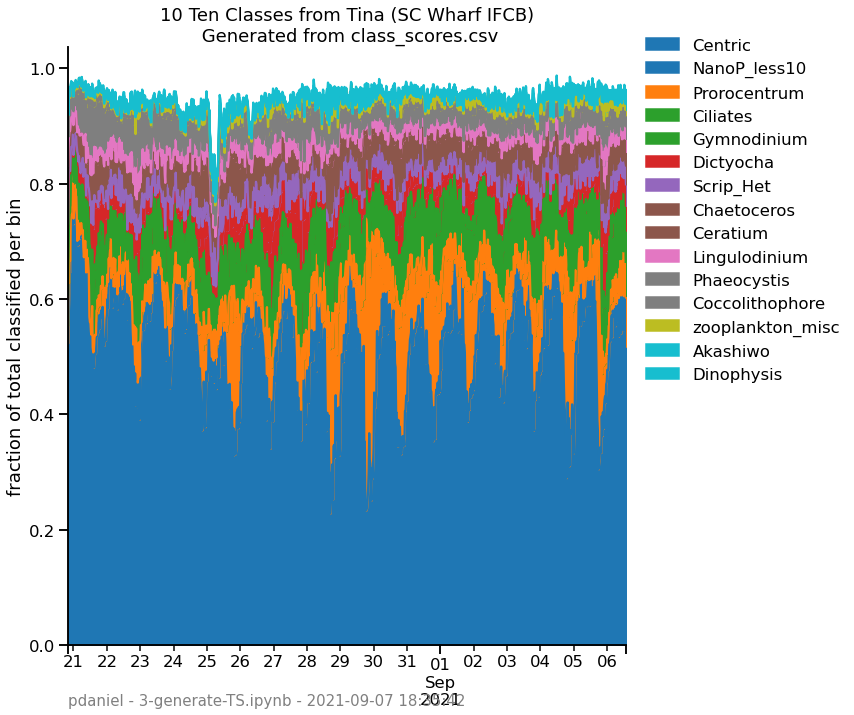

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(10,11)

df_reindexed[top_cols].plot.area(ax=ax,cmap="tab10")

ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("fraction of total classified per bin")
ax.set_xlim(df_reindexed.index[0],df_reindexed.index[-1]);
ax.set_title("10 Ten Classes from Tina (SC Wharf IFCB)\n Generated from class_scores.csv")

ax.text(0,
         -.1,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

sns.despine()
# plt.savefig('./figures/top_data_stacked_normal.png',dpi=300,bbox_inches='tight',transparent=False)

## Load Whaft Shore Station ##

In [21]:
shore = pd.read_csv('./data/210609.csv',skiprows=[1])
shore['dateTime'] = pd.to_datetime(shore["Date Time"])
shore.index = shore['dateTime']
shore2 = pd.read_csv('./data/210622.csv',skiprows=[1])
shore2['dateTime'] = pd.to_datetime(shore2["Date Time"])
shore2.index = shore2['dateTime']
shore = pd.concat((shore,shore2))


<AxesSubplot:xlabel='dateTime'>

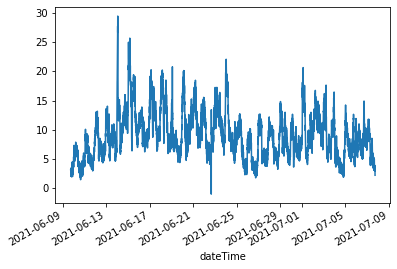

In [23]:
shore['Chl'].plot()

Text(-0.1, -0.4, 'pdaniel - 3-generate-TS.ipynb - 2021-07-22 23:22:57')

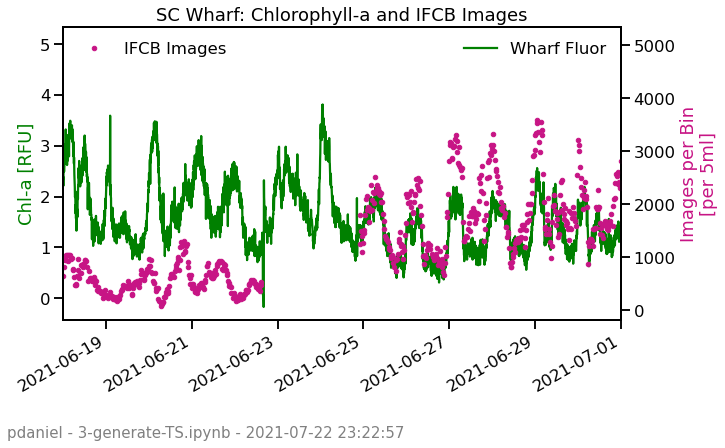

In [82]:
sns.set_context('talk')
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
ax2 = ax.twinx()
ax2.plot(df['dateTime'], df['nsamples'], c='#C71585',lw=0,marker='.',label='IFCB Images')
ax2.set_ylabel('Images per Bin\n[per 5ml]',color = "#C71585")
ax.plot(shore['dateTime'], shore['Chl.1'],color='g',label='Wharf Fluor')
ax.set_ylabel('Chl-a [RFU]', color='g')
ax.legend(fancybox=False, loc=1,frameon=False)
ax2.legend(fancybox=False, loc=2 ,frameon=False)
fig.autofmt_xdate()
ax.set_xlim(dt.datetime(2021,6,18),dt.datetime(2021,7,1))
ax2.set_xlim(dt.datetime(2021,6,18),dt.datetime(2021,7,1))


plt.title("SC Wharf: Chlorophyll-a and IFCB Images")
ax.text(-.1,
         -.4,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

# sns.despine()

Text(-0.1, -0.4, 'pdaniel - 3-generate-TS.ipynb - 2021-07-22 23:21:25')

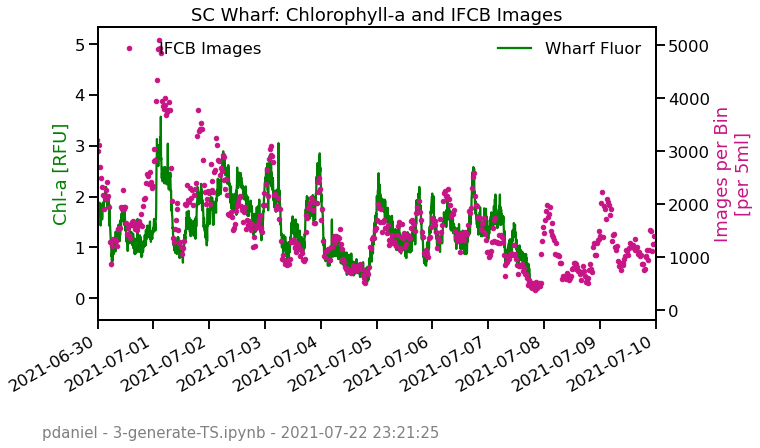

In [81]:
sns.set_context('talk')
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
ax2 = ax.twinx()
ax2.plot(df['dateTime'], df['nsamples'], c='#C71585',lw=0,marker='.',label='IFCB Images')
ax2.set_ylabel('Images per Bin\n[per 5ml]',color = "#C71585")
ax.plot(shore['dateTime'], shore['Chl.1'],color='g',label='Wharf Fluor')
ax.set_ylabel('Chl-a [RFU]', color='g')
ax.legend(fancybox=False, loc=1,frameon=False)
ax2.legend(fancybox=False, loc=2 ,frameon=False)
fig.autofmt_xdate()
ax.set_xlim(dt.datetime(2021,6,30),dt.datetime(2021,7,10))
ax2.set_xlim(dt.datetime(2021,6,30),dt.datetime(2021,7,10))


plt.title("SC Wharf: Chlorophyll-a and IFCB Images")
ax.text(-.1,
         -.4,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

# sns.despine()